https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-Job_descriptions

This project consists of finding a correlation between job descriptions and skills.

# 3. Analyze Knowledge, Skills, and Tasks from Job Descriptions

## 1. Import packages

In [ ]:
# pip install numpy pandas sklearn wordcloud Descriptionblob

In [243]:
import numpy as np # linear algebra
import pandas as pd # data processing, json file I/O (e.g. pd.read_json)
import string
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

import os
for dirname, _, filenames in os.walk('/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 2. Import Data

In [244]:
test = pd.read_csv('data-jobs-20221123.csv', encoding='utf-8')

## Delete empty rows
test = test.dropna()

print("\n ** raw data **\n")
print(test.head())
print("\n ** data shape **\n")
print(test.shape)


 ** raw data **

                                           job_title           role  \
0       Identity and Access Management Administrator  administrator   
1              Systems Administrator (Hybrid Remote)  administrator   
2                          IT Administrator/Helpdesk  administrator   
3                    IT Administrator/Helpdesk L2/L3  administrator   
4  Identity Access Management AD Systems Administ...  administrator   

                                         description  
0  Job Summary\nThe Identity and Access Managemen...  
1  Systems Administrator (Hybrid Remote)\n\nChris...  
2  IT Administrator/Helpdesk\nIf you are a IT Adm...  
3  IT Administrator/Helpdesk L2/L3\nIf you are a ...  
4  Deloitte Global is the engine of the Deloitte ...  

 ** data shape **

(453, 3)


## 3. Plot Roles

<AxesSubplot: >

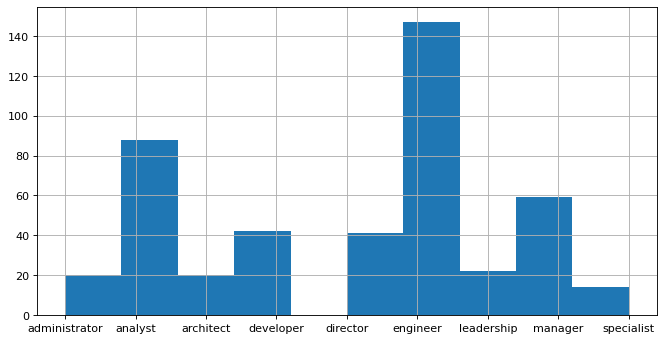

In [245]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
test.role.hist()

## 4. Process Data

In [247]:
## Lower case
test['description'] = test['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['description'] = test['description'].str.replace('[^\w\s]',' ', regex=True)
## digits
test['description'] = test['description'].str.replace('\d+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
other_stop_words = ['']

stop.extend(other_stop_words)

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
test.head()


Preprocessed data: 



,job_title,role,description
0,Identity and Access Management Administrator,administrator,identity access management shall responsible p...
1,Systems Administrator (Hybrid Remote),administrator,christar interdenominational mission organizat...
2,IT Administrator/Helpdesk,administrator,least two year heart silicon valley unified co...
3,IT Administrator/Helpdesk L2/L3,administrator,l l least two year heart silicon valley unifie...
4,Identity Access Management AD Systems Administ...,administrator,engine network professional reach across disci...


## 5. Aggregate descriptions by role

In [211]:
## jda stands for job description aggregated
jda = test.groupby(['role']).sum().reset_index()
print("Aggregated job descriptions: \n")

jda.head()

Aggregated job descriptions: 



,role,description,job_title
0,administrator,identity access management shall responsible p...,Identity and Access Management AdministratorSy...
1,analyst,adp identity access management iam position al...,Senior IAM Technical AnalystHRIS Analyst ISyst...
2,architect,seeking identity access management iam archite...,Identity and Access Management ArchitectLead I...
3,developer,using api connection flat file ingests parse j...,Data Integration DeveloperHRIS SQL DeveloperAp...
4,director,abbott healthcare leader people live stage lif...,"Director, Identity and Access ManagementDirect..."


## 6. Word cloud of each role


*** administrator ***



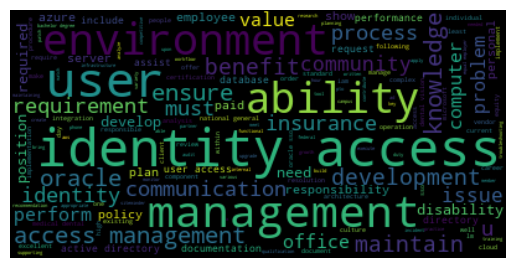


*** analyst ***



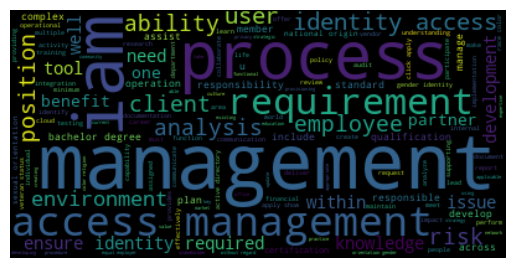


*** architect ***



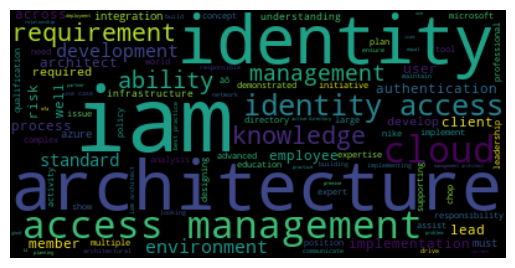


*** developer ***



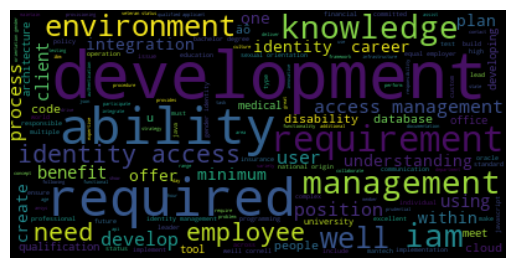


*** director ***



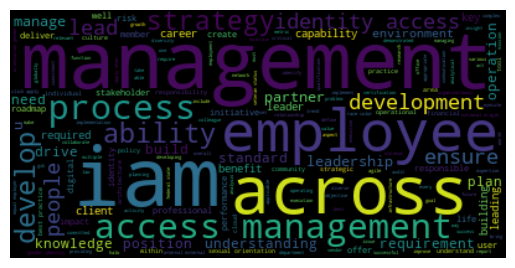


*** engineer ***



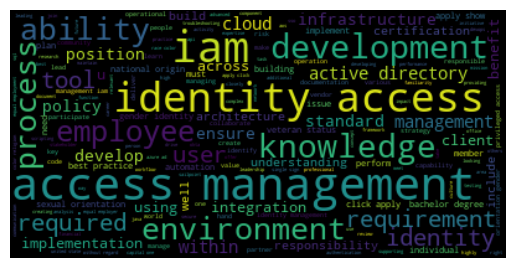


*** leadership ***



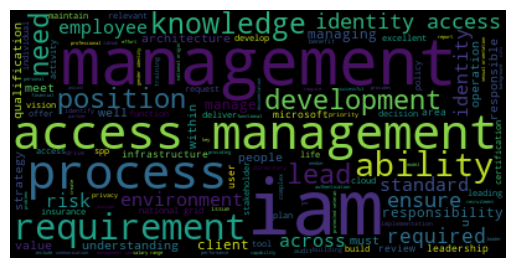


*** manager ***



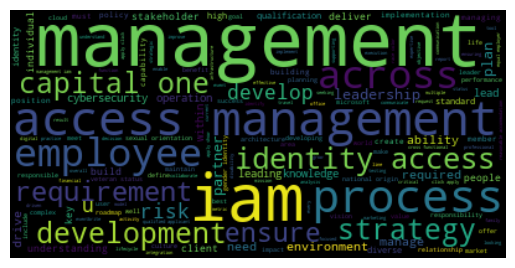


*** specialist ***



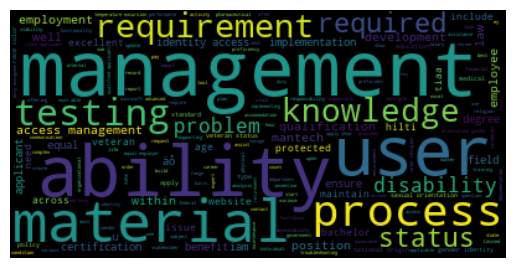

In [212]:
## Visualize data
jobs_list = jda.role.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.role == job].iloc[0].description

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


## 7. Model

In [230]:
## Converting text to features 
vectorizer = TfidfVectorizer(min_df=0.3, max_df=0.8)
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description)
y = test.role

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (319, 143)
test data shape:  (80, 143)


<AxesSubplot: >

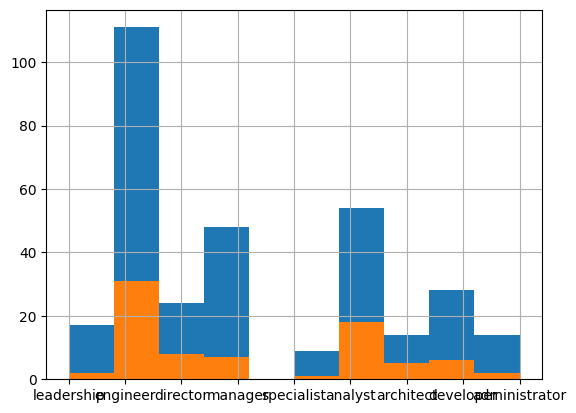

In [217]:
y_train.hist()
y_test.hist()

In [231]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.4
Classes: (to help read Confusion Matrix)
 ['administrator' 'analyst' 'architect' 'developer' 'director' 'engineer'
 'leadership' 'manager' 'specialist']
Confusion Matrix: 
[[ 0  0  0  0  0  2  0  0  0]
 [ 0  1  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  5  0  3  0]
 [ 0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]]
Classification Report: 
               precision    recall  f1-score   support

administrator       0.00      0.00      0.00         2
      analyst       1.00      0.06      0.11        18
    architect       0.00      0.00      0.00         5
    developer       0.00      0.00      0.00         6
     director       0.00      0.00      0.00         8
     engineer       0.41      1.00      0.58        31
   leadership       0.00      0.00      0.00         2
      manager       0.00      0.00      0.00         7
   specialist

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:

6 technical skills
6 adjectives
To do so, we use the library TextBlob to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.

In [236]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn','numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow','linux','ruby','javaScript','django','react','reactjs','ai','ui','tableau', 'directory', 'virtual directory', 'radiant logic', 'sailpoint', 'identity proofing', 'identity aggregations', 'identity lifecycle management', 'deprovisioning', 'account management', 'entitlements', 'attribute management', 'reconciliation', 'resolution', 'identity management', 'ldap','active directory', 'azure active directory', 'ad', 'aad', 'mim', 'microsoft identity manager', 'access reviews', 'identity governance and administration', 'identity governance', 'iga', 'recertification', 'entrust', 'venafi', 'one time pin', 'otp' 'FIDO', 'pki', 'enrollment', 'credential management', 'password', 'push notification', 'okta', 'ping', 'single sign-on', 'SSO', 'public key infrastructure', 'authentication', 'authorization', 'access management', 'abac', 'access control', 'saml', 'oidc', 'open id connect', 'active directory federation services', 'adfs', 'policy decision point', 'two-factor authentication', 'tfa', 'mfa', 'multifactor authentication', 'privileged access management', 'pam', 'cyberark', 'beyondtrust', 'thycotic',  'privileged account management', 'policy alignment', 'authentication broker', 'attribute exchange', 'trust framework', 'assertion service', 'federation assertion', 'saml', 'oidc', 'open id connect', 'security token service', 'sts', 'trust relationship', 'azure', 'aws', 'directory','iam']
feature_array = vectorizer.get_feature_names_out()
# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)
    
    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:6]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'title':clf.classes_[i],
                        'technical_skills':top_technical_skills,
                        'soft_skills':top_adjectives },
                       ignore_index=True)


**** administrator ****

list of unprocessed skills :
['user' 'directory' 'must' 'ensure' 'issue' 'active' 'computer'
 'knowledge' 'benefit' 'environment' 'national' 'applicant' 'day'
 'medical']

**** analyst ****

list of unprocessed skills :
['requirement' 'iam' 'analysis' 'process' 'risk' 'user' 'ability'
 'knowledge' 'position' 'employee' 'required' 'client' 'report' 'partner']

**** architect ****

list of unprocessed skills :
['iam' 'architecture' 'cloud' 'authentication' 'lead' 'client' 'directory'
 'standard' 'environment' 'well' 'type' 'knowledge' 'requirement'
 'ability']

**** developer ****

list of unprocessed skills :
['development' 'requirement' 'client' 'medical' 'iam' 'required' 'ability'
 'position' 'disability' 'status' 'benefit' 'offer' 'minimum' 'employee']

**** director ****

list of unprocessed skills :
['iam' 'strategy' 'across' 'leadership' 'partner' 'lead' 'employee'
 'ability' 'build' 'people' 'manage' 'drive' 'plan' 'client']

**** engineer ****

list of 

/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_7569/342774100.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_7569/342774100.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_7569/342774100.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append({'title':clf.classes_[i],
/var/folders/1q/13518n1s1n75fzdx64wlyz5w0000gn/T/ipykernel_7569/342774100.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [235]:
print(output.T)

                                                             0           1  \
title                                            administrator     analyst   
technical_skills                                   [directory]          []   
soft_skills       [user, active, national, applicant, medical]  [required]   

                                            2                   3  \
title                               architect           developer   
technical_skills  [directory, authentication]                  []   
soft_skills            [iam, lead, directory]  [medical, minimum]   

                              4                            5               6  \
title                  director                     engineer      leadership   
technical_skills             []  [authentication, directory]              []   
soft_skills       [lead, drive]                       [user]  [need, salary]   

                        7           8  
title             manager  specialist  
technical